In [1]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)
        
    print('The archive is extracted into folder: %s' % download_path)

In [3]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['movies']

In [4]:
archive_url = f'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
download_path = '/content'

In [5]:
try_download(archive_url, download_path)

The archive is extracted into folder: /content


In [6]:
ratings=pd.read_csv('/content/ml-latest-small/ratings.csv')
movies=pd.read_csv('/content/ml-latest-small/movies.csv')

In [16]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [30]:
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [27]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [32]:
from sklearn.preprocessing import LabelEncoder

In [33]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [35]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X,y

(array([[   0,    0],
        [   0,    2],
        [   0,    5],
        ...,
        [ 609, 9444],
        [ 609, 9445],
        [ 609, 9485]]), array([4., 4., 4., ..., 5., 5., 3.], dtype=float32))

In [37]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

In [38]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [43]:
X_train_array[0].shape

(90752,)

In [42]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2


Using TensorFlow backend.


In [44]:
#Direct Dot product similarity between Movies and Users
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [45]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
____________________________________________________________________________________________

In [46]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 13s 140us/step - loss: 9.4239 - val_loss: 3.1927
Epoch 2/5
90752/90752 [==============================] - 13s 138us/step - loss: 1.9621 - val_loss: 1.6148
Epoch 3/5
90752/90752 [==============================] - 13s 142us/step - loss: 1.1151 - val_loss: 1.3480
Epoch 4/5
90752/90752 [==============================] - 13s 141us/step - loss: 0.8648 - val_loss: 1.2741
Epoch 5/5
90752/90752 [==============================] - 13s 140us/step - loss: 0.7379 - val_loss: 1.2421


In [47]:
#Adding Bias to the Embedding layers and Concatenating The dot product with individual vectors
from keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [48]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

In [49]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 14s 149us/step - loss: 1.2111 - val_loss: 0.8633
Epoch 2/5
90752/90752 [==============================] - 14s 155us/step - loss: 0.6963 - val_loss: 0.7493
Epoch 3/5
90752/90752 [==============================] - 14s 150us/step - loss: 0.5196 - val_loss: 0.7291
Epoch 4/5
90752/90752 [==============================] - 13s 146us/step - loss: 0.3925 - val_loss: 0.7354
Epoch 5/5
90752/90752 [==============================] - 13s 147us/step - loss: 0.3014 - val_loss: 0.7510


In [50]:
#Concat the user and movie matrix and pass into Dense layers
from keras.layers import Concatenate, Dense, Dropout
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [51]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        30500       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        486200      input_6[0][0]                    
____________________________________________________________________________________________

In [52]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 14s 151us/step - loss: 0.9275 - val_loss: 0.7994
Epoch 2/5
90752/90752 [==============================] - 14s 152us/step - loss: 0.7627 - val_loss: 0.7777
Epoch 3/5
90752/90752 [==============================] - 13s 148us/step - loss: 0.7281 - val_loss: 0.7766
Epoch 4/5
90752/90752 [==============================] - 14s 151us/step - loss: 0.7116 - val_loss: 0.7842
Epoch 5/5
90752/90752 [==============================] - 14s 151us/step - loss: 0.6992 - val_loss: 0.7884


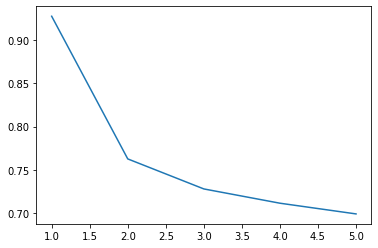

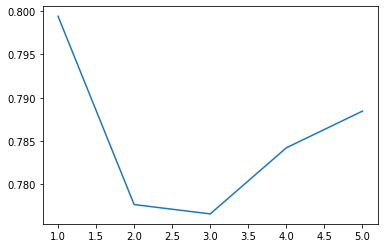

In [54]:
epochs=np.arange(1,6)
plt.figure(1)
plt.plot(epochs,history.history['loss'])
plt.figure(2)
plt.plot(epochs,history.history['val_loss'])

In [59]:
#RNN based network instead of Dense layer
from keras.layers import Concatenate, Dense, Dropout,LSTM
def RecommenderRNN(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x=LSTM(50,return_state=True,return_sequence=True,recurrent_initializer='glorot_uniform')
    #x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [60]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        30500       input_9[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        486200      input_10[0][0]                   
____________________________________________________________________________________________

In [61]:

history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 15s 165us/step - loss: 0.9604 - val_loss: 0.7971
Epoch 2/5
90752/90752 [==============================] - 15s 160us/step - loss: 0.7699 - val_loss: 0.7847
Epoch 3/5
90752/90752 [==============================] - 14s 157us/step - loss: 0.7320 - val_loss: 0.7768
Epoch 4/5
90752/90752 [==============================] - 14s 160us/step - loss: 0.7150 - val_loss: 0.7783
Epoch 5/5
90752/90752 [==============================] - 15s 161us/step - loss: 0.7013 - val_loss: 0.7891


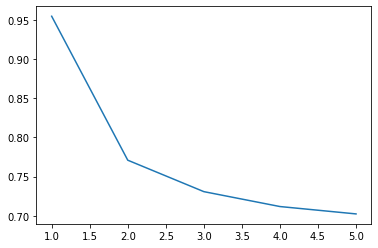

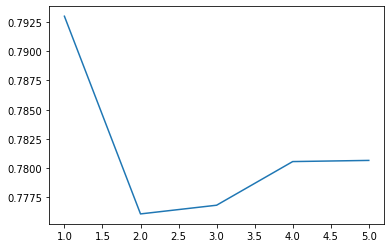

In [58]:
epochs=np.arange(1,6)
plt.figure(1)
plt.plot(epochs,history.history['loss'])
plt.figure(2)
plt.plot(epochs,history.history['val_loss'])

In [66]:
# Deep and wide network
from keras.layers import Concatenate, Dense, Dropout,LSTM
def RecommenderRNN(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    
    j=Dense(2,kernel_initializer='he_normal')([user,movie])
    j = Activation('relu')(j)
    j = Dropout(0.5)(j)

    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x=LSTM(100,return_state=True,return_sequence=True,recurrent_initializer='glorot_uniform')
    x = Dropout(0.5)(x)
    
    x=[x,j]
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [69]:
model = RecommenderNet(n_users, n_movies,n_factors, min_rating, max_rating)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 150)       91500       input_15[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 150)       1458600     input_16[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
85120/90752 [===========================>..] - ETA: 2s - loss: 0.9200